### Выбор наилуйчшей модели Uplift. Максимизация ключевых KPI.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn import metrics, cross_validation
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from utils import Dummyfier, prepare, evaluate_clf, uplift, print_metrics #print_metrics_2

%matplotlib inline
#%pylab inline
#!pip install C:/Users/Liksakov/Downloads/imbalanced_learn-0.3.3-py3-none-any.whls

C:\Users\Liksakov\AppData\Local\Continuum\anaconda3_2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# maybe we can make long train_data: hsatck it with CGF==1 and CGF == 0 and make 2*n predictions vector 
def uplift_at(y_tr, cgf_tr, uplift_tr, 
              y_ts, cgf_ts, uplift_ts, at=0.4):
    
    tmp_tr = pd.DataFrame( 
        data  = np.vstack((y_tr, cgf_tr, uplift_tr)).transpose(),
        columns = ['target','cgf','uplift']  
        )
    tmp_tr.sort_values('uplift', ascending=False, inplace=True)
    tmp_tr = tmp_tr.head(int(at*tmp_tr.shape[0]))
    real_uplift_tr =  np.round(tmp_tr[tmp_tr['cgf']==0]['target'].mean() - tmp_tr[tmp_tr['cgf']==1]['target'].mean(),4) 
    if y_ts is not None:
            tmp_ts = pd.DataFrame( 
                data  = np.vstack((y_ts, cgf_ts, uplift_ts)).transpose(),
                columns = ['target','cgf','uplift']  
                )
            tmp_ts.sort_values('uplift', ascending=False, inplace=True)
            tmp_ts = tmp_ts.head(int(at*tmp_ts.shape[0]))
            real_uplift_ts =  np.round(tmp_ts[tmp_ts['cgf']==0]['target'].mean() - tmp_ts[tmp_ts['cgf']==1]['target'].mean(),4)
        
    return real_uplift_tr, real_uplift_ts

In [27]:
# maybe we can make long train_data: hsatck it with CGF==1 and CGF == 0 and make 2*n predictions vector 
def KPI_at(y_tr, cgf_tr, uplift_tr, 
           y_ts, cgf_ts, uplift_ts, 
           income_df, at=0.5):
    
    id_cols = ['CLIENT_ID', 'CONTRACT_REF', 'START_DATE']
    cgf_tr = cgf_tr.reset_index().merge(income_df, how='left', on=id_cols).set_index(id_cols)
    cgf_tr.drop('SCENARIO_NAME_UNI', axis=1, inplace=True)
    tmp_tr = pd.DataFrame( 
        data  = np.vstack((y_tr, cgf_tr.values.T, uplift_tr)).transpose(),
        columns = ['target','cgf','income_3','income_6','uplift']  
        )
    tmp_tr.sort_values('uplift', ascending=False, inplace=True)
    tmp_tr = tmp_tr.head(int(at*tmp_tr.shape[0]))
    real_uplift_tr =  np.round(tmp_tr[tmp_tr['cgf']==0]['target'].mean() - tmp_tr[tmp_tr['cgf']==1]['target'].mean(),4)
    real_inc3_tr = round(np.mean(tmp_tr['income_3']))
    real_inc6_tr = round(np.mean(tmp_tr['income_6']))
    if y_ts is not None:
            cgf_ts = cgf_ts.reset_index().merge(income_df, how='left', on=id_cols).set_index(id_cols)
            cgf_ts.drop('SCENARIO_NAME_UNI', axis=1, inplace=True)
            tmp_ts = pd.DataFrame( 
                data  = np.vstack((y_ts, cgf_ts.values.T, uplift_ts)).transpose(),
                columns = ['target','cgf','income_3','income_6','uplift']  
                )
            tmp_ts.sort_values('uplift', ascending=False, inplace=True)
            tmp_ts = tmp_ts.head(int(at*tmp_ts.shape[0]))
            real_uplift_ts =  np.round(tmp_ts[tmp_ts['cgf']==0]['target'].mean() - tmp_ts[tmp_ts['cgf']==1]['target'].mean(),4)
            real_inc3_ts = round(np.mean(tmp_ts['income_3']))
            real_inc6_ts = round(np.mean(tmp_ts['income_6']))
    
    out_df = pd.DataFrame(
        data = np.matrix([[ real_uplift_tr, real_inc3_tr ,real_inc6_tr],
                       [ real_uplift_ts, real_inc3_ts, real_inc6_ts]]).T,
         columns = ['train', 'test'],
         index = ['uplift', 'income_3m', 'income_6m']
    )     
    return out_df

In [28]:
def offline_simulate_res(X_train, y_train, seed_split, seed_algo, parms_array, income_data):
    # 1. split 
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, 
                                               test_size=0.3,
                                               random_state=seed_split,
                                               shuffle=True,
                                               stratify=X_train['CONTROL_GROUP_FLG'])
    # 2.1 set params
    xgb_estimator = xgb.XGBClassifier( max_depth = int(parms_array[0]), 
                                       n_estimators = int(parms_array[1]),
                                       learning_rate = parms_array[2],
                                       min_child_weight = int(parms_array[3]),
                                       objective='binary:logistic',
                                       seed = seed_algo)
    # 3. Fit.
    xgb_estimator.fit(X_tr, y_tr)
    
    # 4. Get feature importance
    importance_xgb = pd.DataFrame(
        data = {
                'Feature': X_tr.columns.tolist(),
                'Importance': xgb_estimator.feature_importances_
        })
    top_imp_feat = importance_xgb.sort_values('Importance', ascending=False).head(30)

    # 5. estimate probs
    prob_tr_xgb_0 = xgb_estimator.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_tr.columns])[:,1]
    prob_tr_xgb_1 = xgb_estimator.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_tr.columns])[:,1]
    uplift_tr_xgb = prob_tr_xgb_0 - prob_tr_xgb_1

    prob_val_xgb_0 = xgb_estimator.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_val.columns])[:,1]
    prob_val_xgb_1 = xgb_estimator.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_val.columns])[:,1]
    uplift_val_xgb = prob_val_xgb_0 - prob_val_xgb_1

    # 5. Save results
    out = KPI_at(y_tr, X_tr['CONTROL_GROUP_FLG'], uplift_tr_xgb,
                 y_val, X_val['CONTROL_GROUP_FLG'], uplift_val_xgb, 
                 income_data, at=0.5)
    return out, top_imp_feat

In [ ]:
def offline_simulate_res_2(X_train, y_train, seed_split, seed_algo, parms_array, income_data):
    # 1. split 
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, 
                                               test_size=0.3,
                                               random_state=seed_split,
                                               shuffle=True,
                                               stratify=X_train['CONTROL_GROUP_FLG'])
    # 2.1 set params
    xgb_estimator = xgb.XGBClassifier( max_depth = int(parms_array[0]), 
                                       n_estimators = int(parms_array[1]),
                                       learning_rate = parms_array[2],
                                       min_child_weight = int(parms_array[3]),
                                       objective='binary:logistic',
                                       seed = seed_algo)
    # 3. Fit.
    xgb_estimator.fit(X_tr, y_tr)
    
    # 4. Get feature importance
    importance_xgb = pd.DataFrame(
        data = {
                'Feature': X_tr.columns.tolist(),
                'Importance': xgb_estimator.feature_importances_
        })
    top_imp_feat = importance_xgb.sort_values('Importance', ascending=False).head(30)

    # 5. estimate probs
    prob_tr_xgb_0 = xgb_estimator.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_tr.columns])[:,1]
    prob_tr_xgb_1 = xgb_estimator.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_tr.columns])[:,1]
    uplift_tr_xgb = prob_tr_xgb_0 - prob_tr_xgb_1

    prob_val_xgb_0 = xgb_estimator.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_val.columns])[:,1]
    prob_val_xgb_1 = xgb_estimator.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_val.columns])[:,1]
    uplift_val_xgb = prob_val_xgb_0 - prob_val_xgb_1

    # 5. Save results
    out = KPI_at(y_tr, X_tr['CONTROL_GROUP_FLG'], uplift_tr_xgb,
                 y_val, X_val['CONTROL_GROUP_FLG'], uplift_val_xgb, 
                 income_data, at=0.5)
    return out, top_imp_feat

In [4]:
train = pd.read_csv('./train_data/train_dataset.csv', sep='>', na_values='<null>', 
                 parse_dates=['START_DATE', 'LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT', 'BIRTH_DATE'])
print('Train dataset size: ', train.shape)
train.head(2)

Train dataset size:  (114720, 215)


,CONTRACT_REF,CLIENT_ID,CONTROL_GROUP_FLG,START_DATE,TARGET,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,...,TXN_TP_POS_N_180,TXN_TP_POS_N_31,TXN_TP_POS_N_90,TXN_TP_POS_SUM_180,TXN_TP_POS_SUM_31,TXN_TP_POS_SUM_90,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180
0,273-P-99431598,105098373,N,2017-01-23,1,ГОРЯЧИЙКЛЮЧ,RU,ГОРЯЧИЙКЛЮЧ,RU,КАМЫШИН,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,274-P-23967129,101763714,N,2017-04-08,1,МУРМАНСК,RU,МУРМАНСК,RU,АХТУБИНСК,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
test = pd.read_csv('./test_data/test_dataset.csv', 
                   sep='>', na_values='<null>', 
                   parse_dates=['LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT', 'BIRTH_DATE', 'START_DATE'])
print('Dataset size: ', test.shape)
#test = test.set_index(['CONTRACT_REF', 'CLIENT_ID'])
test.head(2)

Dataset size:  (92691, 212)


,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,13_AddrCountry,BAL,BANK,BIRTH_DATE,CARD_CONTR_COUNT_0,...,TXN_TP_POS_N_180,TXN_TP_POS_N_31,TXN_TP_POS_N_90,TXN_TP_POS_SUM_180,TXN_TP_POS_SUM_31,TXN_TP_POS_SUM_90,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,BBKK,1986-12-29,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,BBKK,1968-03-11,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


In [6]:
print( set(train.columns)  - set(test.columns))
print( set(test.columns) -  set(train.columns))

{'SCENARIO_NAME_UNI', 'TARGET', 'CONTROL_GROUP_FLG'}
set()


In [15]:
#train['SCENARIO_NAME_UNI'].value_counts()
# MAP SC_i  = UVEL_i  for i in 1:6
# This scenarious are same
#scenario_mapper = {'Sc_1':'UVEL_1', 'Sc_2':'UVEL_2','Sc_3':'UVEL_3','Sc_4':'UVEL_4','Sc_5':'UVEL_5','Sc_6':'UVEL_6'}
#Xy_train['SCENARIO_NAME'] = Xy_train['SCENARIO_NAME_UNI'].map(scenario_mapper)
#unchanged_index = Xy_train['SCENARIO_NAME'].notnull().values
#Xy_train['SCENARIO_NAME'][~ unchanged_index] = Xy_train['SCENARIO_NAME_UNI'][~ unchanged_index]

In [12]:
dummy = [u'CL_FAM_ST', u'CL_OFF_POS', u'CL_OWN_TYPE', u'LAST_CARD_STATUS', 'CL_ESTATE_TYPE', 
         'CL_INDUSTR', 'CL_SOC_ST', 'ZODIAC']
d = Dummyfier(dummy, drop_old=True)

Xy_train = prepare(train)
Xy_train = d.fit_transform(Xy_train)

na_cols_train = Xy_train.isna().any()
na_cols_train = na_cols_train[na_cols_train==True].index.tolist()
Xy_train = Xy_train.fillna(value=Xy_train[na_cols_train].mean())

y_train = Xy_train['TARGET'].values.flatten()

identity = ['CONTRACT_REF', 'CLIENT_ID', 'SCENARIO_NAME_UNI', 'START_DATE']
X_train = Xy_train.set_index(identity)
X_train.drop(['TARGET'], axis=1, inplace=True)
#X_train = Xy_train.drop(['TARGET'] + identity, axis=1)

X_test = prepare(test)
X_test = d.transform(X_test)

na_cols_test = X_test.isna().any()
na_cols_test = na_cols_test[na_cols_test==True].index.tolist()
# NOT SO GOOD IDEA!
X_test = X_test.fillna(value=X_test[na_cols_test].mean())

X_test = X_test.drop('START_DATE', axis=1)
# Set FLAG  = 0
X_test['CONTROL_GROUP_FLG'] = 0
X_test = X_test[X_train.columns.tolist()]

In [ ]:
X_train.head()

In [25]:
#X_train.head()
#X_test.head()

In [13]:
np.mean(y_train)

0.044517085076708506

In [10]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, 
                                           test_size=0.3,
                                           random_state=42232,
                                           shuffle=True,
                                           stratify=X_train['CONTROL_GROUP_FLG'])

In [11]:
print(X_tr.shape[0])
print(X_val.shape[0])
print('\nCheck  split stratification by taget:')
print(round(np.mean(y_tr),3))
print(round(np.mean(y_val),3))

80304
34416

Check  split stratification by taget:
0.044
0.046


### 1. Построение одной модели для тестовой и контрольной групп

In [1416]:
scaler = StandardScaler()
lr_estimator = LogisticRegression(penalty='l1', C=1e+3, random_state=42)

pipeline = Pipeline( steps=[ 
     ('scaling', scaler),
     ('fitting', lr_estimator)
   ])

In [1419]:
%%time
pipeline.fit(X_tr, y_tr)

Wall time: 1min 22s


Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('fitting', LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [1446]:
importances = pd.DataFrame(
    data = {
        'feature': X_tr.columns.tolist(),
        'tscore': pipeline.get_params().get('fitting').coef_[0]
    }
)
importances = importances.reindex(importances.tscore.abs().sort_values(inplace=False, ascending=False).index)
#importances.head(20)

In [1421]:
pred_prob_val = pipeline.predict_proba(X_val)[:,1]
pred_prob_tr = pipeline.predict_proba(X_tr)[:,1]

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(pred_prob_tr, bins=100, color='red')
axes[0].title.set_text('Predicted probabilities train')
axes[1].hist(pred_prob_val, bins=100, color='blue')
axes[1].title.set_text('Predicted probabilities val');

In [312]:
#X_tr['CONTROL_GROUP_FLG'].value_counts() 

In [313]:
#tmp = X_tr.loc[X_tr['CONTROL_GROUP_FLG'] == 0, 'CONTROL_GROUP_FLG'] = 1
#tmp = X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)
#tmp['CONTROL_GROUP_FLG'].value_counts()

Важно! При вызове predict критично важно, чтобы признаки были именно в таком же порядке и с такими же названиями, 
что и при обучении!

In [1422]:
print('Predict train/test uplifts per each client')
prob_tr_0 = pipeline.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_tr.columns])[:,1]
prob_tr_1 = pipeline.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_tr.columns])[:,1]
uplift_tr = prob_tr_0 - prob_tr_1

prob_val_0 = pipeline.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_val.columns])[:,1]
prob_val_1 = pipeline.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_val.columns])[:,1]
uplift_val = prob_val_0 - prob_val_1

Predict train/test uplifts per each client


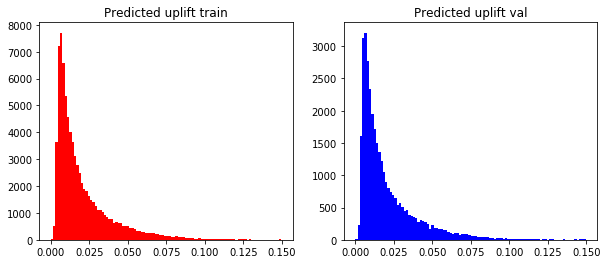

In [336]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(uplift_tr, bins=100, color='red')
axes[0].title.set_text('Predicted uplift train')
axes[1].hist(uplift_val, bins=100, color='blue')
axes[1].title.set_text('Predicted uplift val');

In [277]:
#print(len(y_tr))
#print(len(uplift_tr))
#print(len(X_tr['CONTROL_GROUP_FLG'].values))

In [1423]:
u_tr, u_val = uplift_at(y_tr, X_tr['CONTROL_GROUP_FLG'].values, uplift_tr,
                        y_val, X_val['CONTROL_GROUP_FLG'].values, uplift_val, 
                        at=0.4)
print('Uplift on train:', u_tr)
print('Uplift on test:',  u_val)

Uplift on train: 0.0366
Uplift on test: 0.0415


In [1424]:
real_uplift =  np.round(train[train['CONTROL_GROUP_FLG']=='N']['TARGET'].mean() - train[train['CONTROL_GROUP_FLG']=='Y']['TARGET'].mean() , 4)
print('Real data uplift:',real_uplift)

Real data uplift: 0.0207


Подход 1 с признаком контрольной группы работает (классификатор - лог-регрессия).
Uplft@40% на данных получается около (0.0355 , 0.0426), чувствителен к разбиению и не очень чуствительный к параметрам. 


In [281]:
# Uplift on train 0.0386
# Uplift on test 0.0394

# Uplift on train: 0.0365
# Uplift on test: 0.0419

# Uplift on train: 0.0355
# Uplift on test: 0.0426

# Uplift on train: 0.0383  #  Uplift on train: 0.0381
# Uplift on test: 0.0397   #  Uplift on test: 0.0392

Все тоже самое для XGB классификатора.

In [1454]:
xgb_estimator = xgb.XGBClassifier( max_depth=4, 
                                   n_estimators=100,
                                   learning_rate=0.05,
                                   gamma=0,
                                   min_child_weight=1,
                                   njobs=-1,
                                   #col_sample_bytree=0.8,
                                   #subsample=1,
                                   #reg_alpha=1,
                                   #reg_gamma=1,
                                   #scale_pos_weight=1,
                                   objective='binary:logistic',
                                   seed=2101432
                                   )

In [1455]:
%%time
xgb_estimator.fit(X_tr, y_tr)

Wall time: 37.3 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, njobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2101432, silent=True, subsample=1)

In [1456]:
# feature importance
importance_xgb = pd.DataFrame(
    data = {
            'Feature': X_tr.columns.tolist(),
            'Importance': xgb_estimator.feature_importances_
    })

print(importance_xgb.sort_values('Importance', ascending=False).head(10))

                       Feature  Importance
74      LAST_CONTR_STATUS_TIME    0.147925
40  TOTAL_BAL_POS_CHNG_MAX_180    0.116466
73       LAST_CARD_STATUS_TIME    0.092369
0            CONTROL_GROUP_FLG    0.069612
2           CARD_CONTR_COUNT_0    0.064926
1                          BAL    0.054886
6                    CL_AMT_ZP    0.044177
28        LIM_AVG_N_POS_CHANGE    0.042838
30                  LIM_RECENT    0.039491
69                         AGE    0.024766


In [1450]:
# def Uplift_At(estimator, X_tr,y_tr, X_ts, y_ts, at=0.4):
#     prob_tr_0 = pipeline.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_tr.columns])[:,1]
#     prob_tr_xgb_1 = pipeline.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_tr.columns])[:,1]
#     uplift_tr = prob_tr_xgb_0 - prob_tr_xgb_1

#     prob_val_0 = pipeline.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_val.columns])[:,1]
#     prob_val_1 = pipeline.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_val.columns])[:,1]
#     uplift_val = prob_val_0 - prob_val_1

In [1457]:
print('Predict train/test uplifts per each client')
prob_tr_xgb_0 = xgb_estimator.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_tr.columns])[:,1]
prob_tr_xgb_1 = xgb_estimator.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_tr.columns])[:,1]
uplift_tr_xgb = prob_tr_xgb_0 - prob_tr_xgb_1

prob_val_xgb_0 = xgb_estimator.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 0)[X_val.columns])[:,1]
prob_val_xgb_1 = xgb_estimator.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1).assign(CONTROL_GROUP_FLG = 1)[X_val.columns])[:,1]
uplift_val_xgb = prob_val_xgb_0 - prob_val_xgb_1

Predict train/test uplifts per each client


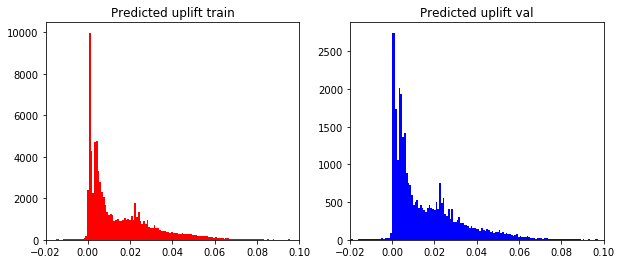

In [1458]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(uplift_tr_xgb, bins=300, color='red')
axes[0].title.set_text('Predicted uplift train')
axes[0].set_xlim([-0.02,0.10])
axes[1].hist(uplift_val_xgb, bins=300, color='blue')
axes[1].title.set_text('Predicted uplift val')
axes[1].set_xlim([-0.02,0.10]);

In [1459]:
u_tr_xgb, u_val_xgb = uplift_at(y_tr, X_tr['CONTROL_GROUP_FLG'].values, uplift_tr_xgb,
                        y_val, X_val['CONTROL_GROUP_FLG'].values, uplift_val_xgb, 
                        at=0.4)
print('Uplift on train:', u_tr_xgb)
print('Uplift on test:',  u_val_xgb)

Uplift on train: 0.0508
Uplift on test: 0.0416


In [ ]:
# Uplift on train: 0.0569
# Uplift on test: 0.0431
    
# Uplift on train: 0.0393
# Uplift on test: 0.0409
       
# max_depth=4, n_estimators=400, learning_rate=0.05
# Uplift on train: 0.0615  0.0626  0.0602  0.056 0.0572  0.0603 0.0508
# Uplift on test: 0.0449 0.0422  0.0452  0.056  0.0521 0.0468  0.0416

In [ ]:
# GOOD PARAMS - CHECK!

In [377]:
# Corr matrix for predictions

### 2. Построение двух моделей отдельно.

In [611]:
scaler = StandardScaler()

lr_estimator_t = LogisticRegression(penalty='l1', C=1e-1, random_state=42)
lr_estimator_c = LogisticRegression(penalty='l1', C=1e-1, random_state=42)

pipeline_t = Pipeline( steps=[ 
     ('scaling', scaler),
     ('fitting', lr_estimator_t)
   ])

pipeline_c = Pipeline( steps=[
    ('scaling', scaler),
    ('fitting', lr_estimator_c)
])

In [612]:
%%time
# FIT 2 lr models:
cgf_ind = X_tr['CONTROL_GROUP_FLG']==1
cgf_ind = cgf_ind.values

pipeline_t.fit(X_tr[~cgf_ind].drop('CONTROL_GROUP_FLG', axis=1), y_tr[~cgf_ind] )
pipeline_c.fit(X_tr[cgf_ind].drop('CONTROL_GROUP_FLG', axis=1), y_tr[cgf_ind])

Wall time: 24.5 s


In [613]:
sign_t = pd.DataFrame( data={'Features': [x for x in  X_tr.columns.tolist() if x!='CONTROL_GROUP_FLG' ],
                             't-score': pipeline_t.get_params().get('fitting').coef_[0]})
sign_c = pd.DataFrame( data={'Features': [x for x in  X_tr.columns.tolist() if x!='CONTROL_GROUP_FLG' ],
                             't-score': pipeline_c.get_params().get('fitting').coef_[0]})

In [614]:
#train['CL_FAM_ST'].value_counts(dropna=False)

In [615]:
print( sign_t.assign(abs_score = abs(sign_t['t-score'])).sort_values('abs_score', ascending=False).head(10), '\n')
print( sign_c.assign(abs_score = abs(sign_c['t-score'])).sort_values('abs_score', ascending=False).head(10), '\n')

                               Features   t-score  abs_score
56                        TOTAL_SUM_180 -0.415728   0.415728
50                        TOTAL_MAX_180  0.316597   0.316597
85  CL_OWN_TYPE_dummy_PRIVATECOMMERCIAL -0.223026   0.223026
73               LAST_CONTR_STATUS_TIME -0.219355   0.219355
36             TOTAL_BAL_NEG_CHNG_N_180  0.208186   0.208186
38              TOTAL_BAL_NEG_CHNG_N_90 -0.197678   0.197678
27                 LIM_AVG_N_POS_CHANGE -0.194087   0.194087
44             TOTAL_BAL_POS_CHNG_N_180  0.186023   0.186023
87           LAST_CARD_STATUS_dummy_176 -0.162057   0.162057
1                    CARD_CONTR_COUNT_0  0.153028   0.153028 

                                   Features   t-score  abs_score
44                 TOTAL_BAL_POS_CHNG_N_180  0.364690   0.364690
0                                       BAL -0.228923   0.228923
87               LAST_CARD_STATUS_dummy_176 -0.228859   0.228859
72                    LAST_CARD_STATUS_TIME -0.197580   0.197580
59

In [580]:
# Why so different - ? #have to be approx the same
# Check feature distrib

In [616]:
print('Predict train/test uplifts per each client')
prob_tr_t = pipeline_t.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1))[:,1]
prob_tr_c = pipeline_c.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1))[:,1]
uplift_tr_2mod = prob_tr_t - prob_tr_c

prob_val_t = pipeline_t.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1))[:,1]
prob_val_c = pipeline_c.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1))[:,1]
uplift_val_2mod = prob_val_t - prob_val_c

Predict train/test uplifts per each client


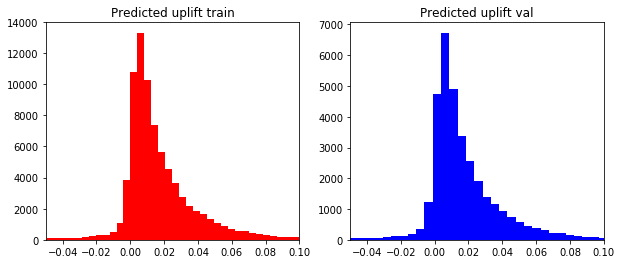

In [617]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(uplift_tr_2mod, bins=300, color='red')
axes[0].title.set_text('Predicted uplift train')
axes[0].set_xlim([-0.05, 0.1])
axes[1].hist(uplift_val_2mod, bins=300, color='blue')
axes[1].title.set_text('Predicted uplift val')
axes[1].set_xlim([-0.05, 0.1]);

In [618]:
u_tr_2mod, u_val_2mod = uplift_at(y_tr, X_tr['CONTROL_GROUP_FLG'].values, uplift_tr_2mod,
                        y_val, X_val['CONTROL_GROUP_FLG'].values, uplift_val_2mod, 
                        at=0.4)
print('Uplift on train:', u_tr_2mod)
print('Uplift on test:',  u_val_2mod)

Uplift on train: 0.045
Uplift on test: 0.0343


In [ ]:
# Uplift on train: 0.0501
# Uplift on test: 0.0353 

# L1 regularized C = 1e-2
# Uplift on train: 0.0384 0.0432 0.045
# Uplift on test: 0.038 0.0304  0.0343

# L2 regularized
# Uplift on train: 0.0454
# Uplift on test: 0.0346

Две отдельные модели для XGB классификатора

In [680]:
xgb_estimator_t = xgb.XGBClassifier(   max_depth=4, 
                                       n_estimators=400,
                                       learning_rate=0.05,
                                       njobs=-1,
                                       objective='binary:logistic',
                                       seed=40)

xgb_estimator_c = xgb.XGBClassifier(   max_depth=4, 
                                       n_estimators=400,
                                       learning_rate=0.05,
                                       njobs=-1,
                                       objective='binary:logistic',
                                       seed=40)

In [681]:
%%time
# FIT 2 XGB models:
cgf_ind = X_tr['CONTROL_GROUP_FLG']==1
cgf_ind = cgf_ind.values

xgb_estimator_t.fit(X_tr[~cgf_ind].drop('CONTROL_GROUP_FLG', axis=1), y_tr[~cgf_ind])
xgb_estimator_c.fit(X_tr[cgf_ind].drop('CONTROL_GROUP_FLG', axis=1), y_tr[cgf_ind])

Wall time: 2min 27s


In [682]:
sign_xgb_t = pd.DataFrame( data={'Features': [x for x in  X_tr.columns.tolist() if x!='CONTROL_GROUP_FLG' ],
                                 'Importance': xgb_estimator_t.feature_importances_ })

sign_xgb_c = pd.DataFrame( data={'Features': [x for x in  X_tr.columns.tolist() if x!='CONTROL_GROUP_FLG' ],
                                 'Importance': xgb_estimator_c.feature_importances_})

print( sign_xgb_t.sort_values('Importance', ascending=False).head(10), '\n')
print( sign_xgb_c.sort_values('Importance', ascending=False).head(10), '\n')

                      Features  Importance
73      LAST_CONTR_STATUS_TIME    0.083466
39  TOTAL_BAL_POS_CHNG_MAX_180    0.069588
72       LAST_CARD_STATUS_TIME    0.067407
0                          BAL    0.045004
5                    CL_AMT_ZP    0.038858
68                         AGE    0.036677
34              REP_POPULATION    0.036281
29                  LIM_RECENT    0.031919
41  TOTAL_BAL_POS_CHNG_MIN_180    0.031721
47  TOTAL_BAL_POS_CHNG_SUM_180    0.028747 

                      Features  Importance
73      LAST_CONTR_STATUS_TIME    0.055402
72       LAST_CARD_STATUS_TIME    0.051708
0                          BAL    0.050785
29                  LIM_RECENT    0.049861
5                    CL_AMT_ZP    0.047784
68                         AGE    0.042705
39  TOTAL_BAL_POS_CHNG_MAX_180    0.041551
43   TOTAL_BAL_POS_CHNG_MIN_90    0.031625
47  TOTAL_BAL_POS_CHNG_SUM_180    0.031394
34              REP_POPULATION    0.030702 



In [683]:
print('Predict train/test uplifts per each client')
prob_tr_xgb_t = xgb_estimator_t.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1))[:,1]
prob_tr_xgb_c = xgb_estimator_c.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1))[:,1]
uplift_tr_xgb_2mod = prob_tr_xgb_t - prob_tr_xgb_c

prob_val_xgb_t = xgb_estimator_t.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1))[:,1]
prob_val_xgb_c = xgb_estimator_c.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1))[:,1]
uplift_val_xgb_2mod = prob_val_xgb_t - prob_val_xgb_c

Predict train/test uplifts per each client


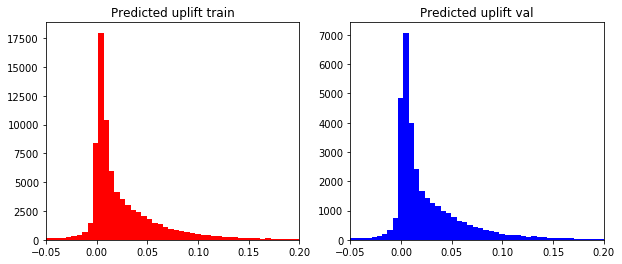

In [684]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(uplift_tr_xgb_2mod, bins=300, color='red')
axes[0].title.set_text('Predicted uplift train')
axes[0].set_xlim([-0.05, 0.2])
axes[1].hist(uplift_val_xgb_2mod, bins=300, color='blue')
axes[1].title.set_text('Predicted uplift val')
axes[1].set_xlim([-0.05, 0.2]);

In [685]:
u_tr_xgb_2mod, u_val_xgb_2mod = uplift_at(y_tr, X_tr['CONTROL_GROUP_FLG'].values, uplift_tr_xgb_2mod,
                        y_val, X_val['CONTROL_GROUP_FLG'].values, uplift_val_xgb_2mod, 
                        at=0.4)
print('Uplift on train:', u_tr_xgb_2mod)
print('Uplift on test:',  u_val_xgb_2mod)

Uplift on train: 0.0958
Uplift on test: 0.0412


In [ ]:
# max_depth=4, n_estimators=400, learning_rate=0.05
# Uplift on train: 0.0954 0.0958
# Uplift on test: 0.0408 0.0412

# max_depth=4, n_estimators=100, learning_rate=0.05
# Uplift on train: 0.0738 0.0731 0.0715 0.074
# Uplift on test: 0.0409 0.043 0.0458 0.04

# max_depth=6, n_estimators=200, learning_rate=0.02
# Uplift on train: 0.0896
# Uplift on test:  0.0387

# max_depth=3, n_estimators=100, learning_rate=0.1
# Uplift on train: 0.0736
# Uplift on test:  0.0399

### 3. Подход "Class Modification"

In [1350]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, 
                                           test_size=0.3,
                                           random_state=78,
                                           shuffle=True,
                                           stratify=X_train['CONTROL_GROUP_FLG'])

Для того, чтобы подход работал необходимо, чтобы число наблюдений в двух группах совпадало.
Для этого досемплируем наблюдения из контрольной группы, чтобы их было столько же, сколько и в тестовой(с которой коммуницировали).

In [1039]:
# smote = SMOTE(random_state=42)
# ones_ind = (y_tr == 1)
# # do this with target == 1 and target==0 independently
# X_tr_bal_1, cgf_1 = smote.fit_sample(X_tr[ones_ind].drop('CONTROL_GROUP_FLG', axis=1), 
#                                      X_tr['CONTROL_GROUP_FLG'][ones_ind].values) # returns np arrays
# X_tr_bal_0, cgf_0 = smote.fit_sample(X_tr[~ones_ind].drop('CONTROL_GROUP_FLG', axis=1),
#                                      X_tr['CONTROL_GROUP_FLG'][~ones_ind].values) # returns np arrays

# X_tr_bal_1 = pd.DataFrame(X_tr_bal_1, columns=[ x for x in X_tr.columns if x!='CONTROL_GROUP_FLG'])
# X_tr_bal_0 = pd.DataFrame(X_tr_bal_0, columns=[ x for x in X_tr.columns if x!='CONTROL_GROUP_FLG'])
# X_tr_bal_1 = X_tr_bal_1.assign(CONTROL_GROUP_FLG = cgf_1)
# X_tr_bal_0 = X_tr_bal_0.assign(CONTROL_GROUP_FLG = cgf_0)
# X_tr_bal = pd.concat([X_tr_bal_1, X_tr_bal_0], axis=0)
# X_tr_bal = X_tr_bal[X_tr.columns.tolist()]
# y_tr_bal = np.concatenate( (np.ones(len(cgf_1)),np.zeros(len(cgf_0))), axis=0)
# # data is not shuffled here

In [1040]:
# print(X_tr_bal_1.shape[0])
# print(X_tr_bal_0.shape[0])
# print(X_tr_bal.shape[0])
# #print(len(y_tr_bal_c))
# print(np.mean(y_tr_bal))
# print(np.mean(y_tr))

In [1041]:
# print( X_tr_bal.shape)
# print( len(y_tr_bal) )
# print( np.mean(y_tr_bal))
# print( np.mean(X_tr_bal['CONTROL_GROUP_FLG'])) # 0.1506 used to be in initial data

In [1042]:
# print(len(y_tr_inv))
# print(len(y_val_inv))
# print(len(y_val))

В SMOTE легко ошибиться, поэтому просто сделаем undersampling имеющихся наблюдений из тестовой группы.

In [1092]:
X_tr_bal = pd.concat([
    X_tr[X_tr['CONTROL_GROUP_FLG']==0].sample(n=np.sum(X_tr['CONTROL_GROUP_FLG'].values), random_state=43),
    X_tr[X_tr['CONTROL_GROUP_FLG']==1]
], axis=0)

y_tr_bal = np.concatenate( (pd.Series(y_tr[X_tr['CONTROL_GROUP_FLG']==0]).sample(n=np.sum(X_tr['CONTROL_GROUP_FLG'].values),random_state=43).values,
                            y_tr[X_tr['CONTROL_GROUP_FLG']==1]), axis=0)

X_tr_bal, y_tr_bal = shuffle(X_tr_bal, y_tr_bal)

Или наоборот, делаем oversampling:

In [1067]:
print(X_tr[X_tr['CONTROL_GROUP_FLG']==0].shape)
print(X_tr[X_tr['CONTROL_GROUP_FLG']==1].shape)

(68213, 140)
(12091, 140)


In [1351]:
X_tr_bal = pd.concat([
    X_tr[X_tr['CONTROL_GROUP_FLG']==0],
    X_tr[X_tr['CONTROL_GROUP_FLG']==1].sample(n=X_tr[X_tr['CONTROL_GROUP_FLG']==0].shape[0], 
                                              replace=True, random_state=44)
], axis=0)

y_tr_bal = np.concatenate( (pd.Series(y_tr[X_tr['CONTROL_GROUP_FLG']==0]),
                            pd.Series(y_tr[X_tr['CONTROL_GROUP_FLG']==1]).\
                            sample(n=X_tr[X_tr['CONTROL_GROUP_FLG']==0].shape[0], replace=True, random_state=44)))

X_tr_bal, y_tr_bal = shuffle(X_tr_bal, y_tr_bal)

In [1352]:
print(round(np.mean(y_tr_bal),4))
print(X_tr_bal.shape)

0.0372
(136426, 140)


In [1353]:
# make NEW invers target Z:
y_tr_inv = y_tr_bal*(1.0 - X_tr_bal['CONTROL_GROUP_FLG'].values) + \
            (1.0 - y_tr_bal)*(X_tr_bal['CONTROL_GROUP_FLG'].values) 
y_val_inv = y_val*(1.0 - X_val['CONTROL_GROUP_FLG'].values) + \
            (1.0 - y_val)*(X_val['CONTROL_GROUP_FLG'].values) 

In [1354]:
print(round(np.mean(y_tr_inv),4)) # 0.5096
print(round(np.mean(y_val_inv),4)) # 0.1883

0.5105
0.1867


In [1355]:
scaler = StandardScaler()

lr_estimator_inv = LogisticRegression(penalty='l2', C=1e+3, random_state=42)

pipeline_inv = Pipeline( steps=[ 
     ('scaling', scaler),
     ('fitting', lr_estimator_inv)
   ])

In [1356]:
%%time
pipeline_inv.fit(X_tr_bal.drop('CONTROL_GROUP_FLG',  axis=1), y_tr_bal)

Wall time: 19.2 s


Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('fitting', LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [1357]:
sign_inv = pd.DataFrame( data={'Features': [x for x in  X_tr.columns.tolist() if x!='CONTROL_GROUP_FLG' ],
                               't-score':  pipeline_t.get_params().get('fitting').coef_[0]})
print( sign_inv.assign(abs_score = abs(sign_inv['t-score'])).sort_values('abs_score', ascending=False).head(10))

                               Features   t-score  abs_score
56                        TOTAL_SUM_180 -0.415728   0.415728
50                        TOTAL_MAX_180  0.316597   0.316597
85  CL_OWN_TYPE_dummy_PRIVATECOMMERCIAL -0.223026   0.223026
73               LAST_CONTR_STATUS_TIME -0.219355   0.219355
36             TOTAL_BAL_NEG_CHNG_N_180  0.208186   0.208186
38              TOTAL_BAL_NEG_CHNG_N_90 -0.197678   0.197678
27                 LIM_AVG_N_POS_CHANGE -0.194087   0.194087
44             TOTAL_BAL_POS_CHNG_N_180  0.186023   0.186023
87           LAST_CARD_STATUS_dummy_176 -0.162057   0.162057
1                    CARD_CONTR_COUNT_0  0.153028   0.153028


In [1358]:
uplift_tr_inv =  1*(pipeline_inv.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1))[:,1]) #- 1
uplift_val_inv = 1*(pipeline_inv.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1))[:,1]) #- 1

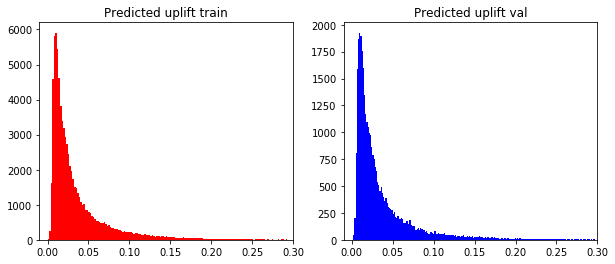

In [1359]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(uplift_tr_inv, bins=500, color='red')
axes[0].title.set_text('Predicted uplift train')
axes[0].set_xlim([-0.01, 0.3])
axes[1].hist(uplift_val_inv, bins=500, color='blue')
axes[1].title.set_text('Predicted uplift val')
axes[1].set_xlim([-0.01, 0.3]);

In [1360]:
u_tr_inv, u_val_inv = uplift_at(y_tr, X_tr['CONTROL_GROUP_FLG'].values, uplift_tr_inv,
                        y_val, X_val['CONTROL_GROUP_FLG'].values, uplift_val_inv, 
                        at=0.4)
print('Uplift on train:',u_tr_inv)
print('Uplift on test:',u_val_inv)

Uplift on train: 0.0352
Uplift on test: 0.0344


In [1362]:
R = KPI_at(y_tr, X_tr['CONTROL_GROUP_FLG'], uplift_tr_inv,
           y_val, X_val['CONTROL_GROUP_FLG'], uplift_val_inv, 
           income_data, at=0.4)
print(R)

              train      test
uplift       0.0352    0.0344
income_3m  129.0000  126.0000
income_6m  290.0000  302.0000


In [1033]:
# Uplift on train: 0.0355
# Uplift on test: 0.0358

# Uplift on train: 0.0328
# Uplift on test: 0.0407

# Uplift on train: 0.0307
# Uplift on test: 0.0373

#Uplift on train: 0.0357 0.0362
#Uplift on test: 0.0295  0.0292

#Uplift on train: 0.0356
#Uplift on test: 0.0313

In [1365]:
xgb_estimator_inv = xgb.XGBClassifier( max_depth=4, 
                                       n_estimators=1000,
                                       learning_rate=0.01,
                                       njobs=-1,
                                       objective='binary:logistic',
                                       seed=45)

In [1366]:
%%time
xgb_estimator_inv.fit(X_tr_bal.drop('CONTROL_GROUP_FLG',  axis=1), y_tr_bal)

Wall time: 10min 14s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, njobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=45, silent=True, subsample=1)

In [1367]:
uplift_tr_inv_xgb =  1*(xgb_estimator_inv.predict_proba(X_tr.drop('CONTROL_GROUP_FLG', axis=1))[:,1]) #- 1
uplift_val_inv_xgb = 1*(xgb_estimator_inv.predict_proba(X_val.drop('CONTROL_GROUP_FLG', axis=1))[:,1])# - 1

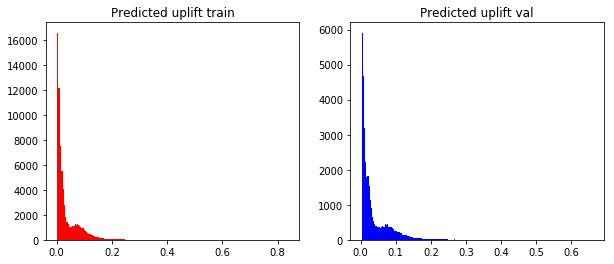

In [1368]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(uplift_tr_inv_xgb, bins=200, color='red')
axes[0].title.set_text('Predicted uplift train')
#axes[0].set_xlim([-0.05, 0.2])
axes[1].hist(uplift_val_inv_xgb, bins=200, color='blue')
axes[1].title.set_text('Predicted uplift val')
#axes[1].set_xlim([-0.05, 0.2]);

In [1369]:
u_tr_inv_xgb, u_val_inv_xgb = uplift_at(y_tr, X_tr['CONTROL_GROUP_FLG'].values, uplift_tr_inv_xgb,
                        y_val, X_val['CONTROL_GROUP_FLG'].values, uplift_val_inv_xgb, 
                        at=0.4)
print('Uplift on train:',u_tr_inv_xgb)
print('Uplift on test:',u_val_inv_xgb)

Uplift on train: 0.0412
Uplift on test: 0.0371


In [1114]:
# Uplift on train: 0.0398
# Uplift on test: 0.0352

#Uplift on train: 0.0404
#Uplift on test: 0.0364

#Uplift on train: 0.0385
#Uplift on test: 0.0415

# n_est = 700
#Uplift on train: 0.0387
#Uplift on test: 0.0397

ВЫВОДЫ: -Все подходы работают, так как uplift@40% для всех подходов как минимум больше 0.3, что принципиально 
        отличается от 0.2 на.
        -Лучше всех работает XGB классификатор первого и второго подходов. (С точки зрения uplift@40%)
        -Есть предположение, что для логистической регрессии необходимо сделать feature selection, 
        так как регрессоров очень много.
        -Результаты метрики зависят достаточно сильно от seed, что затрудняет процесс выбора лучшей модели. 
        Изменение параметров модели также значительно влияет на результат.

Считываем данные по доходу: (ещё один KPI)

In [14]:
income_data = pd.read_csv('income_micro.csv', delimiter='>', decimal='.', parse_dates=['START_DATE', 'END_DATE'] )
income_data.drop(['CREATE_DTTM', 'SCENARIO_NAME', 'CONTROL_GROUP_FLG', 'END_DATE'], axis=1, inplace=True)
income_data = income_data.rename({'DOHOD_3':'income_3','DOHOD_6':'income_6'}, axis='columns', inplace=False)
#income_data.set_index(['CLIENT_ID', 'CONTRACT_REF', 'START_DATE'], inplace=True)

In [63]:
#print(tmp_tr.shape)
#print(X_tr.shape)
#print(np.sum(tmp_tr['income_3'].isna().values),'  ', np.sum(tmp_tr['income_6'].isna().values))

In [15]:
# res = KPI_at(y_tr, X_tr['CONTROL_GROUP_FLG'], uplift_tr_inv_xgb,
#              y_val, X_val['CONTROL_GROUP_FLG'], uplift_val_inv_xgb,
#              income_df=income_data, at=0.4)
# print(res)

In [ ]:
#      train          test
# uplift     3.870000e-02  3.970000e-02
# income_3m  4.413341e+06  1.865133e+06
# income_6m  1.010490e+07  4.286080e+06

#             train      test
# uplift       0.0383    0.0375
# income_3m  136.0000  135.0000
# income_6m  310.0000  314.0000

#               train      test
# uplift       0.0412    0.0371
# income_3m  138.0000  135.0000
# income_6m  313.0000  319.0000

Подсчитываем KPI для случайного выбора:

In [16]:
id_cols = ['CONTRACT_REF', 'CLIENT_ID', 'START_DATE']
real_uplift =  np.round(train[train['CONTROL_GROUP_FLG']=='N']['TARGET'].mean() - train[train['CONTROL_GROUP_FLG']=='Y']['TARGET'].mean() , 4)
tmp = train.merge(income_data, how='left', on = id_cols)
inc3_rand = round(np.mean(tmp['income_3'].values))
inc6_rand = round(np.mean(tmp['income_6'].values))
print('Real data uplift:', real_uplift)
print('Real data income 3m per client:', inc3_rand)
print('Real data income 6m per client:', inc6_rand)

Real data uplift: 0.0207
Real data income 3m per client: 64.0
Real data income 6m per client: 147.0


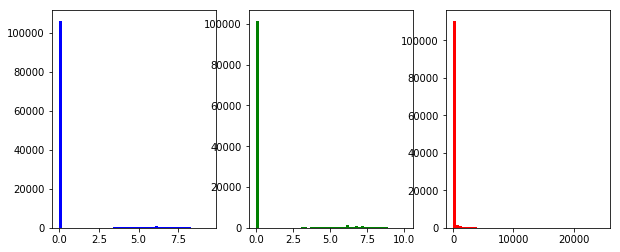

In [17]:
# plot income per 3, 6 month and it's differance:
fig, axes = plt.subplots(1,3, figsize = (10,4))
axes[0].hist( np.log(tmp['income_3'].values+1), bins=50, color='blue')
axes[1].hist( np.log(tmp['income_6']+1), bins=50, color='green')
axes[2].hist(tmp['income_6'] - tmp['income_3'], bins=50, color='red');

In [18]:
print( round(sum(tmp['income_3'] > 0)/tmp.shape[0],3))
print( round(sum(tmp['income_6'] > 0)/tmp.shape[0],3))

0.075
0.115


### Отбор модели меьодом случайной подвыборки.

Будем много (~100) раз менять train/test split разбиение, чтобы получить лучшую оценку средних KPI, а также их разброс для 2 лучших подходов.

In [19]:
# Set XGB params to try:
params_matr = pd.DataFrame(
              np.matrix([[2, 20, 0.3, 1],  
                         [2, 20, 0.3, 6], 
                         [3, 100, 0.1, 5],
                         [3, 100, 0.1, 1], 
                         [3, 1000, 0.01, 1], 
                         [4, 100, 0.05, 1], 
                         [4, 400, 0.05, 1 ], 
                         [4, 1000, 0.01, 1], 
                         [5, 100, 0.1, 1], 
                         [5, 500, 0.01, 1], 
                         [6, 100, 0.05, 1], 
                         [6, 500, 0.005, 1], 
                         [4, 400, 0.05, 5], 
                         [12, 100, 0.05, 1]]))
print(params_matr.shape)

output_df = pd.DataFrame(columns = ['seed_split', 'seed_algo', 'max_depth', 'n_estimators', 'learning_rate', 
                                    'max_child_weight', 'uplift_tr', 'uplift_ts', 'income_3m_tr', 'income_3m_ts',
                                    'income_6m_tr', 'income_6m_ts'])

top_feat_imp = pd.DataFrame(columns = ['X' + str(x) for x in range(30)])

(14, 4)


In [200]:
#%%time
# Example
#a,b = offline_simulate_res(X_train, y_train, seed_split=42232, seed_algo=2101432, parms_array=[6, 10, 0.03, 1 ], 
#                         income_data=income_data)
#print(a)
#print(b.head())

In [ ]:
#Uplift on train: 0.0508
#Uplift on test: 0.0416

#0.0603 
#0.0468 

In [29]:
%%time
for i in range(420):
    seed_split = np.random.randint(0, 1000000, 1)[0]
    seed_algo = np.random.randint(0, 1000000, 1)[0]
    xgb_params = params_matr.loc[i%14,:].values
    tmp_res, feat_import = offline_simulate_res( X_train, y_train, 
                                                 seed_split=seed_split,
                                                 seed_algo=seed_algo, 
                                                 parms_array=xgb_params, 
                                                 #parms_array=[1,20,0.1,1],
                                                 income_data=income_data)
    output_df.loc[i] = [seed_split, seed_algo] + list(xgb_params) + [x for row in tmp_res.values for x in row]
    top_feat_imp.loc[i] = feat_import['Feature'].values.tolist()
    if(i == 100): print(i)
    if(i == 200): print(i)
    if(i == 300): print(i)
    if(i == 400): print(i)

100
200
300
400
Wall time: 15h 6min 21s


In [31]:
output_df.head(3)

,seed_split,seed_algo,max_depth,n_estimators,learning_rate,max_child_weight,uplift_tr,uplift_ts,income_3m_tr,income_3m_ts,income_6m_tr,income_6m_ts
0,801368.0,86357.0,2.0,20.0,0.3,1.0,0.0381,0.0351,105.0,106.0,241.0,239.0
1,971512.0,930758.0,2.0,20.0,0.3,6.0,0.0349,0.0372,111.0,119.0,256.0,271.0
2,422187.0,197247.0,3.0,100.0,0.1,5.0,0.0444,0.0337,106.0,104.0,242.0,243.0


In [32]:
top_feat_imp.head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29
0,TOTAL_BAL_POS_CHNG_MAX_180,CARD_CONTR_COUNT_0,LAST_CONTR_STATUS_TIME,LIM_AVG_N_POS_CHANGE,CONTROL_GROUP_FLG,LAST_CARD_STATUS_TIME,BAL,CL_AMT_ZP,LIM_RECENT,FL_GOLD,...,CL_INDUSTR_dummy_NA,CL_INDUSTR_dummy_FUELCOMPLEX,CL_INDUSTR_dummy_AGRICULTURE,CL_INDUSTR_dummy_EDUCATION,CL_INDUSTR_dummy_ENGINEERING,CL_ESTATE_TYPE_dummy_RENT,LAST_CARD_STATUS_dummy_182,CL_ESTATE_TYPE_dummy_JOINTLYPROPERTY,CL_ESTATE_TYPE_dummy_PERSONALPROPERTY,LAST_CARD_STATUS_dummy_74
1,TOTAL_BAL_POS_CHNG_MAX_180,CARD_CONTR_COUNT_0,LAST_CONTR_STATUS_TIME,CONTROL_GROUP_FLG,BAL,LAST_CARD_STATUS_TIME,FL_GOLD,CL_AMT_ZP,LIM_RECENT,LIM_AVG_CHANGE,...,CL_ESTATE_TYPE_dummy_LIVINGWITHPARENTS,CL_ESTATE_TYPE_dummy_NA,CL_ESTATE_TYPE_dummy_RENT,CL_INDUSTR_dummy_AGRICULTURE,CL_ESTATE_TYPE_dummy_OTHER,LAST_CARD_STATUS_dummy_98,CL_ESTATE_TYPE_dummy_JOINTLYPROPERTY,CL_OWN_TYPE_dummy_NA,CL_FAM_ST_dummy_DIVORCED,CL_FAM_ST_dummy_NA
2,LAST_CONTR_STATUS_TIME,TOTAL_BAL_POS_CHNG_MAX_180,LAST_CARD_STATUS_TIME,CARD_CONTR_COUNT_0,CONTROL_GROUP_FLG,BAL,CL_AMT_ZP,LIM_RECENT,AGE,LIM_AVG_N_POS_CHANGE,...,LIM_AVG_N_CHANGES,TXN_CHN_POS terminal_MAX_180,IS_LOYALTY_AUTO,SIN_BD_MONTH,TOTAL_BAL_POS_CHNG_MIN_31,TXN_TP_Credit_MEAN_180,CL_SOC_ST_dummy_DECREE,LAST_CARD_STATUS_dummy_176,TOTAL_BAL_NEG_CHNG_N_180,CARD_STATUS_176


In [35]:
output_df.to_csv('model_results/one_mod_simulation_results.csv', index=False, decimal=',')

In [34]:
top_feat_imp.to_csv('model_results/one_mod_top_features.csv', index=False)

In [36]:
output_df.head()

,seed_split,seed_algo,max_depth,n_estimators,learning_rate,max_child_weight,uplift_tr,uplift_ts,income_3m_tr,income_3m_ts,income_6m_tr,income_6m_ts
0,801368.0,86357.0,2.0,20.0,0.30,1.0,0.0381,0.0351,105.0,106.0,241.0,239.0
1,971512.0,930758.0,2.0,20.0,0.30,6.0,0.0349,0.0372,111.0,119.0,256.0,271.0
2,422187.0,197247.0,3.0,100.0,0.10,5.0,0.0444,0.0337,106.0,104.0,242.0,243.0
3,40583.0,191460.0,3.0,100.0,0.10,1.0,0.0428,0.0421,107.0,118.0,247.0,263.0
4,886963.0,13027.0,3.0,1000.0,0.01,1.0,0.0441,0.0370,102.0,100.0,232.0,234.0


In [48]:
output_df_1 = output_df.assign(model_params = output_df['max_depth'].astype(str) + '_' + 
                                              output_df['n_estimators'].astype(str) + '_'  +
                                              output_df['learning_rate'].astype(str) + '_' + 
                                              output_df['max_child_weight'].astype(str))

In [49]:
output_df_1.head()

,seed_split,seed_algo,max_depth,n_estimators,learning_rate,max_child_weight,uplift_tr,uplift_ts,income_3m_tr,income_3m_ts,income_6m_tr,income_6m_ts,model_params
0,801368.0,86357.0,2.0,20.0,0.30,1.0,0.0381,0.0351,105.0,106.0,241.0,239.0,2.0_20.0_0.3_1.0
1,971512.0,930758.0,2.0,20.0,0.30,6.0,0.0349,0.0372,111.0,119.0,256.0,271.0,2.0_20.0_0.3_6.0
2,422187.0,197247.0,3.0,100.0,0.10,5.0,0.0444,0.0337,106.0,104.0,242.0,243.0,3.0_100.0_0.1_5.0
3,40583.0,191460.0,3.0,100.0,0.10,1.0,0.0428,0.0421,107.0,118.0,247.0,263.0,3.0_100.0_0.1_1.0
4,886963.0,13027.0,3.0,1000.0,0.01,1.0,0.0441,0.0370,102.0,100.0,232.0,234.0,3.0_1000.0_0.01_1.0


In [52]:
output_df_1.columns.tolist()

['seed_split',
 'seed_algo',
 'max_depth',
 'n_estimators',
 'learning_rate',
 'max_child_weight',
 'uplift_tr',
 'uplift_ts',
 'income_3m_tr',
 'income_3m_ts',
 'income_6m_tr',
 'income_6m_ts',
 'model_params']

In [55]:
# 30 simulations for each params
#output_df_1.groupby(by = 'model_params').count()
output_df_1.groupby(by = 'model_params')[output_df_1.columns.tolist()[6:12]].mean().sort_values('uplift_ts',ascending=False)

,uplift_tr,uplift_ts,income_3m_tr,income_3m_ts,income_6m_tr,income_6m_ts
model_params,,,,,,
3.0_100.0_0.1_1.0,0.042790,0.039150,105.100000,104.800000,241.566667,241.500000
4.0_400.0_0.05_1.0,0.049777,0.038323,103.566667,102.166667,236.866667,234.166667
4.0_1000.0_0.01_1.0,0.048460,0.038270,103.333333,102.666667,236.233333,236.166667
5.0_500.0_0.01_1.0,0.049343,0.038100,101.300000,100.200000,233.100000,228.933333
6.0_100.0_0.05_1.0,0.058037,0.038037,100.200000,99.600000,229.633333,228.166667
3.0_100.0_0.1_5.0,0.042890,0.038007,105.233333,103.933333,241.333333,240.800000
3.0_1000.0_0.01_1.0,0.043300,0.037740,106.600000,104.600000,244.833333,242.533333
4.0_400.0_0.05_5.0,0.049183,0.037423,102.200000,100.633333,233.733333,230.500000
2.0_20.0_0.3_6.0,0.036723,0.036920,110.033333,110.133333,252.300000,251.900000


In [60]:
out_all_stats  = output_df_1.groupby(by = 'model_params')[output_df_1.columns.tolist()[6:12]].\
                             agg(['mean', 'std', 'min', 'max'])

In [70]:
out_all_stats.columns.levels[0] == 'uplift_ts'#in ['uplift_ts', 'income_3m_ts']

array([False,  True, False, False, False, False])

In [65]:
out_all_stats.columns.get_level_values('uplift_ts')

KeyError: 'Level uplift_ts not found'

In [64]:
out_all_stats.iloc[:, out_all_stats.columns.get_level_values('uplift_ts')]

KeyError: 'Level uplift_ts not found'

In [78]:
scen_data

NameError: name 'scen_data' is not defined